**Question 1 and 2**

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')
if HF_TOKEN is None:
    raise ValueError("HF_TOKEN secret not set. Please add it as a secret in Google Colab.")

import os
os.environ["HF_TOKEN"] = HF_TOKEN


In [5]:
from transformers import pipeline
qa_pipeline = pipeline("question-answering",
                       model="distilbert-base-uncased-distilled-squad",
                       use_auth_token=HF_TOKEN)


Answer: the blast at alahli arab hospital on october 18 which killed hundreds of palestinians


/usr/local/lib/python3.10/dist-packages/plotnine/geoms/geom_path.py:111: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


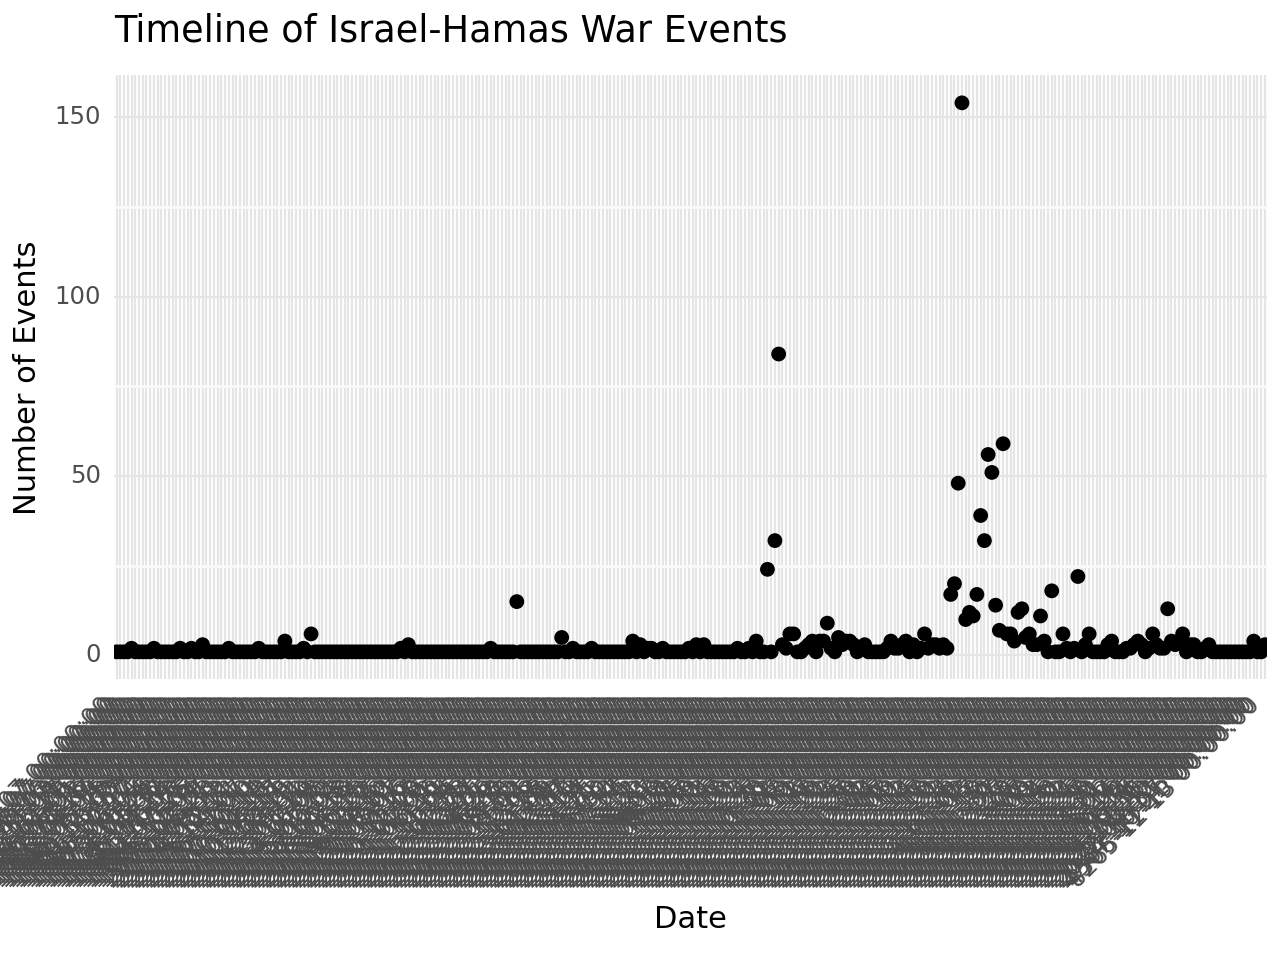

In [3]:
import json
import re
from datetime import datetime
import pandas as pd
from plotnine import ggplot, aes, geom_line, geom_point, labs, theme_minimal, element_text, theme
from transformers import pipeline
import gc


def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = ' '.join(text.split())
    return text.lower()


def is_relevant(article):
    keywords = ['israel', 'hamas', 'gaza', 'palestine']
    return any(keyword in article['articleBody'] for keyword in keywords)


def extract_events(articles):
    events = []
    date_regex = r'\b\d{1,2} \w+ \d{4}\b'
    for article in articles:
        dates = re.findall(date_regex, article['articleBody'])
        for date in dates:
            try:
                event_date = datetime.strptime(date, '%d %B %Y')
                events.append((event_date, article['articleBody']))
            except ValueError:
                continue
    return events


def get_answer(question, articles, qa_pipeline):
    context = ' '.join([article['articleBody'] for article in articles])
    response = qa_pipeline(question=question, context=context)
    return response['answer']


def process_articles(file_path, chunk_size=10):
    with open(file_path, 'r', encoding='utf-8') as file:
        articles = json.load(file)
        for i in range(0, len(articles), chunk_size):
            chunk = articles[i:i + chunk_size]
            relevant_articles = []
            for article in chunk:
                article['articleBody'] = clean_text(article['articleBody'])
                if is_relevant(article):
                    relevant_articles.append(article)
            if relevant_articles:
                yield relevant_articles


file_path = '/content/drive/MyDrive/news.article.json'


qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")


relevant_articles = []
for chunk in process_articles(file_path):
    relevant_articles.extend(chunk)
    if len(relevant_articles) > 100:
        break

# Sample QA
question = "What happened at the Al-Shifa Hospital?"
answer = get_answer(question, relevant_articles, qa_pipeline)
print(f"Answer: {answer}")

events = []
for chunk in process_articles(file_path):
    events.extend(extract_events(chunk))

events.sort(key=lambda x: x[0])


df_events = pd.DataFrame(events, columns=['Date', 'Event'])
del events
gc.collect()


event_counts = df_events.groupby('Date').size().reset_index(name='Counts')

# Create a ggplot-style plot
plot = (ggplot(event_counts, aes(x='Date', y='Counts'))
        + geom_line(size=1.2)
        + geom_point(size=2)
        + labs(title='Timeline of Israel-Hamas War Events', x='Date', y='Number of Events')
        + theme_minimal()
        + theme(axis_text_x=element_text(rotation=45, hjust=1)))

# Display the plot
print(plot)
